# Importing Libraries

In [1062]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from wordcloud import WordCloud

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

#### Constants



In [1049]:
# Data used for analysis
DATA='EURUSD'

# The events data prices before and after the event
HOURS_BEFORE=2
HOURS_AFTER=24

# price columns 
PRICE_COLUMNS = [str(num)+'h' for num in np.arange(-HOURS_BEFORE,HOURS_AFTER+1)]

# Predition columns
PREDICTED_FUTURE_PRICES = ['1h','3h','5h']

# Events information columns
EVENT_COLUMNS = ['time','currency','description','impact','actual','deviation','consensus','previous','result']

# PRICES TO DROP WHICH WE DONT NEED
PRICES_TO_DROP = PRICE_COLUMNS.copy()
for price in PREDICTED_FUTURE_PRICES:
    PRICES_TO_DROP.remove(price)
PRICES_TO_DROP.remove('0h')

# IMPACT COLORS to visualize
IMPACT_COLORS = {
    'low': '#F5C861',
    'medium': '#E4871B',
    'high': '#D25746',
    'none': 'black'
}

NULL_COLUMNS = []

FEATURES_INFO = {
    'time' : 'Time of event occuring',
    'currency': 'Currencies might be affected',
    'description' : 'Event Information',
    'impact': 'The impact is a basic indicator of the potential move a data release might trigger on currencies. Shall a bar be red and long, market observers expect this data to have great probability to move the Forex market. Shall this bar be yellow and short, the probability is viewed as low. In orange, we’re just in between.(Red: High,Orange: Medium,yellow: low, White: none)',
    'actual': 'Actual Value when event occured',
    'deviation': 'It measures the surprise caused when the Actual data differs from the Consensus. It can oscillate in an open scale usually between -7 and +7.',
    'consensus': 'It is a general agreement of experts on the outcome of the number.',
    'previous': 'It is the data in its last release (frequency of data release is variable: it can be last month, last trimester…).',
    'result' : 'Green: better than expected Red: worse than expected, Black : neutral'
}
for item in PRICE_COLUMNS:
    if item.startswith('-') or item.startswith('0h'):
        FEATURES_INFO[item] = 'Price before ' + item + ' of the event'
    else:
        FEATURES_INFO[item] = 'Price after ' + item + ' of the event'

In [1050]:
EVENT_COLUMNS

['time',
 'currency',
 'description',
 'impact',
 'actual',
 'deviation',
 'consensus',
 'previous',
 'result']

In [1051]:
PRICE_COLUMNS

['-2h',
 '-1h',
 '0h',
 '1h',
 '2h',
 '3h',
 '4h',
 '5h',
 '6h',
 '7h',
 '8h',
 '9h',
 '10h',
 '11h',
 '12h',
 '13h',
 '14h',
 '15h',
 '16h',
 '17h',
 '18h',
 '19h',
 '20h',
 '21h',
 '22h',
 '23h',
 '24h']

# Load Data

In [992]:
# Load the data according to the currency
frame = pd.read_csv('./data/economic_events_'+DATA+'.csv',index_col=['time'],header=0)

# Convert the time string to datetime object
frame.index = pd.to_datetime(frame.index,format='%Y-%m-%d %H:%M:%S%z',utc=True)

# hex color actual colum contains the result : positive-green, negative - red, black-neutral
frame.rename(columns={'hex_color_actual':'result'},inplace=True)
type(frame.index)
frame.attrs['features'] = FEATURES_INFO
# Create MultiIndex
# frame['time'] = pd.to_datetime(frame['time'],format='%Y-%m-%d %H:%M:%S%z',utc=True)
# frame.set_index(['time','currency','description'])


# EDA

In [993]:
# Shape of the dataset
frame.shape

(29600, 35)

In [994]:
# Info about the dataset
frame.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 29600 entries, 2013-01-02 09:13:00+00:00 to 2024-06-14 14:00:00+00:00
Data columns (total 35 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   currency     29600 non-null  object 
 1   description  29600 non-null  object 
 2   impact       29600 non-null  object 
 3   actual       29600 non-null  object 
 4   deviation    29600 non-null  object 
 5   consensus    29600 non-null  object 
 6   previous     29600 non-null  object 
 7   result       29600 non-null  object 
 8   -2h          27771 non-null  float64
 9   -1h          27772 non-null  float64
 10  0h           27766 non-null  float64
 11  1h           27733 non-null  float64
 12  2h           27674 non-null  float64
 13  3h           27651 non-null  float64
 14  4h           27641 non-null  float64
 15  5h           27623 non-null  float64
 16  6h           27271 non-null  float64
 17  7h           26984 non-null  float64
 18 

In [995]:
# Basic Stats
frame.describe().T

,count,mean,std,min,25%,50%,75%,max
-2h,27771.0,1.153696,0.090814,0.95555,1.091730,1.128550,1.188990,1.39562
-1h,27772.0,1.153682,0.090833,0.95388,1.091690,1.128550,1.188900,1.39629
0h,27766.0,1.153633,0.090816,0.95437,1.091670,1.128375,1.189070,1.39629
1h,27733.0,1.153586,0.090801,0.95558,1.091700,1.128180,1.189190,1.39629
2h,27674.0,1.153503,0.090835,0.95437,1.091673,1.128090,1.188890,1.39543
3h,27651.0,1.153441,0.090816,0.95739,1.091730,1.127920,1.188530,1.39543
4h,27641.0,1.153448,0.090777,0.95655,1.091720,1.128030,1.188630,1.39492
5h,27623.0,1.153434,0.090771,0.95845,1.091400,1.128040,1.188495,1.39492
6h,27271.0,1.153789,0.090904,0.95930,1.091540,1.128270,1.188430,1.39334
7h,26984.0,1.153769,0.090833,0.95811,1.091770,1.128325,1.188210,1.39339


In [996]:
# Colums in dataset
frame.columns

Index(['currency', 'description', 'impact', 'actual', 'deviation', 'consensus',
       'previous', 'result', '-2h', '-1h', '0h', '1h', '2h', '3h', '4h', '5h',
       '6h', '7h', '8h', '9h', '10h', '11h', '12h', '13h', '14h', '15h', '16h',
       '17h', '18h', '19h', '20h', '21h', '22h', '23h', '24h'],
      dtype='object')

In [997]:
# Head of the dataset
frame.head()

,currency,description,impact,actual,deviation,consensus,previous,result,-2h,-1h,...,15h,16h,17h,18h,19h,20h,21h,22h,23h,24h
time,,,,,,,,,,,,,,,,,,,,,
2013-01-02 09:13:00+00:00,EUR,HCOB Manufacturing PMI(Dec),low,44.6,-0.48,45.1,45.3,red,1.32733,1.32809,...,1.31821,1.31703,1.31267,1.31387,1.31371,1.31382,1.31452,1.31339,1.31636,1.3147
2013-01-02 09:43:00+00:00,EUR,HCOB Manufacturing PMI(Dec),low,46.7,1.20,45.3,45.1,green,1.32733,1.32809,...,1.31821,1.31703,1.31267,1.31387,1.31371,1.31382,1.31452,1.31339,1.31636,1.3147
2013-01-02 09:48:00+00:00,EUR,HCOB Manufacturing PMI(Dec),low,44.6,0.00,44.6,44.6,black,1.32733,1.32809,...,1.31821,1.31703,1.31267,1.31387,1.31371,1.31382,1.31452,1.31339,1.31636,1.3147
2013-01-02 09:53:00+00:00,EUR,HCOB Manufacturing PMI(Dec),medium,46,-0.28,46.3,46.3,red,1.32733,1.32809,...,1.31821,1.31703,1.31267,1.31387,1.31371,1.31382,1.31452,1.31339,1.31636,1.3147
2013-01-02 09:58:00+00:00,EUR,HCOB Manufacturing PMI(Dec),medium,46.1,-0.32,46.3,46.3,red,1.32733,1.32809,...,1.31821,1.31703,1.31267,1.31387,1.31371,1.31382,1.31452,1.31339,1.31636,1.3147


In [998]:
# Last 10 rows of the dataset
frame.tail()

,currency,description,impact,actual,deviation,consensus,previous,result,-2h,-1h,...,15h,16h,17h,18h,19h,20h,21h,22h,23h,24h
time,,,,,,,,,,,,,,,,,,,,,
2024-06-14 08:00:00+00:00,EUR,Global Trade Balance(Apr),low,€4.807B,0.24,€4.25B,€4.296B,green,1.07073,1.06915,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-06-14 09:00:00+00:00,EUR,Trade Balance n.s.a.(Apr),low,€15B,-0.33,€20B,€23.7B,red,1.06915,1.06868,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-06-14 12:30:00+00:00,USD,Export Price Index (MoM)(May),low,-0.6%,-1.39,0%,0.6%,red,1.06934,1.06888,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-06-14 12:30:00+00:00,USD,Import Price Index (MoM)(May),low,-0.4%,-1.65,0.1%,0.9%,red,1.06934,1.06888,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-06-14 14:00:00+00:00,USD,Michigan Consumer Sentiment Index(Jun) PREL,high,65.6,-1.60,72,69.1,red,1.06688,1.06866,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Feature Engineering

## Understanding the features

In [999]:
# Features Info
frame.attrs['features']

{'time': 'Time of event occuring',
 'currency': 'Currencies might be affected',
 'description': 'Event Information',
 'impact': 'The impact is a basic indicator of the potential move a data release might trigger on currencies. Shall a bar be red and long, market observers expect this data to have great probability to move the Forex market. Shall this bar be yellow and short, the probability is viewed as low. In orange, we’re just in between.(Red: High,Orange: Medium,yellow: low, White: none)',
 'actual': 'Actual Value when event occured',
 'deviation': 'It measures the surprise caused when the Actual data differs from the Consensus. It can oscillate in an open scale usually between -7 and +7.',
 'consensus': 'It is a general agreement of experts on the outcome of the number.',
 'previous': 'It is the data in its last release (frequency of data release is variable: it can be last month, last trimester…).',
 'result': 'Green: better than expected Red: worse than expected, Black : neutral

## Feature improvement

### Missing values

It is a statistical technique of replacing missing data with substituted values. Once all missing values have been imputed, the data set can be analyzed using standard techniques. If **5% of data is missing, then it can be ignored** and if **60%-70% of the data is missing then it can be dropped(rule of thumb)**. 

**3 mechanisms of causes of missing data:** https://pressbooks.library.upei.ca/montelpare/chapter/working-with-missing-data/

1. **Missing At Random(MAR):** When there is a systematic relation between inclination if missing values and the observed variable value.
2. **Missing Completely At Random(MCAR):** Where there is no relationship between the missingness of data in a variable with any values in any other variable.
3. **Missing Not At Random(MNAR):** The value of the variable that is missing based on the reason why the data was not provided like a person may not be interested to share the blood group.

**Mechanisms to impute missing data:**

**Single Imputation:** 
Used when only very little bit of data is missing. Each missing data is replaced with single value based on certain strategy.
1. **Summary statistics substitution:** Substitute the missing value of a variable by the statistical summary like mean, median of the observed value of that variable
2. **Regression Imputation:** Replace the missing value by regressing the missing variable on the other variable
Interpolation and extrapolation
3. **Model based imputation:** treat the variable with missing values as target variable and use machine learning algorithm to  predict the missing values.
 

**Multiple Imputation:** 
Used when the data is missing in random but not completely at random. Each missing value is replaced with multiple values based on the information in the portion of dataset. Multiple imputation is used to generate multiple datasets, perform statistical analysis on them, and average the results.
1. **Stochastic regression:** The predicted value of the missing data from the regression plus the residual error values.
Hot deck imputation: Randomly chosen value from an individual in the sample which has similar values on the other variables. Ex: If ‘age’ is a feature between only 5-10, then randomly missing values can be substituted between 5-10.

In [1000]:
for column in EVENT_COLUMNS[1:]:
    frame[column] = frame[column].replace('-', np.nan)
    print(column + ': Null values: ' + str(frame[column].isnull().mean()*100))
    if frame[column].isnull().sum()>0:
        NULL_COLUMNS.append(column)


currency: Null values: 0.0
description: Null values: 0.0
impact: Null values: 0.0
actual: Null values: 0.020270270270270268
deviation: Null values: 0.793918918918919
consensus: Null values: 0.0
previous: Null values: 0.02364864864864865
result: Null values: 0.0


In [1001]:
for column in NULL_COLUMNS:
    print(frame[frame[column].isnull()].shape)

frame.shape


(6, 35)
(235, 35)
(7, 35)


(29600, 35)

In [1002]:
for column in NULL_COLUMNS:
    print('Null column: ' + column + ' details')
    print(frame[frame[column].isnull()][EVENT_COLUMNS[1:]].head())
    

Null column: actual details
                          currency                     description  impact  \
time                                                                         
2013-03-21 14:00:00+00:00      USD  Housing Price Index (MoM)(Jan)  medium   
2014-04-23 07:30:00+00:00      EUR     HCOB Services PMI(Apr) PREL  medium   
2014-04-23 08:00:00+00:00      EUR    HCOB Composite PMI(Apr) PREL  medium   
2014-04-23 08:00:00+00:00      EUR     HCOB Services PMI(Apr) PREL  medium   
2015-06-02 17:30:00+00:00      USD        Total Vehicle Sales(May)     low   

                          actual deviation consensus previous result  
time                                                                  
2013-03-21 14:00:00+00:00    NaN     -0.80      0.7%     0.5%  black  
2014-04-23 07:30:00+00:00    NaN       NaN      53.4       53  black  
2014-04-23 08:00:00+00:00    NaN       NaN      53.1     53.1  black  
2014-04-23 08:00:00+00:00    NaN       NaN      52.4     52.2  black  

Since the actual and consensus and previous info is already embedded into deviation we dont need those columns. We will check further about missing values in the deviation column

deviation = actual - consensus ( check frame.attrs['features']  for more info)

In [1006]:
frame[frame['deviation'].isnull()]['impact'].value_counts()

impact
low       150
medium     68
high       17
Name: count, dtype: int64

### Imputation

1. First we will check the events for which all the prices columns are null

In [1007]:
# frame.drop(frame[PRICE_COLUMNS].isnull().all(axis=1),inplace=True)
frame[frame[PRICE_COLUMNS].isnull().all(axis=1)].tail()

,currency,description,impact,actual,deviation,consensus,previous,result,-2h,-1h,...,15h,16h,17h,18h,19h,20h,21h,22h,23h,24h
time,,,,,,,,,,,,,,,,,,,,,
2024-05-31 12:30:00+00:00,USD,Personal Consumption Expenditures - Price Inde...,medium,0.3%,0.00,0.3%,0.3%,black,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-05-31 12:30:00+00:00,USD,Personal Consumption Expenditures - Price Inde...,medium,2.7%,0.00,2.7%,2.7%,black,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-05-31 12:30:00+00:00,USD,Personal Income (MoM)(Apr),medium,0.3%,0.00,0.3%,0.5%,black,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-05-31 12:30:00+00:00,USD,Personal Spending(Apr),medium,0.2%,-0.62,0.3%,0.7%,red,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-05-31 13:45:00+00:00,USD,Chicago Purchasing Managers' Index(May),medium,35.4,-3.50,41,37.9,red,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [1008]:
frame[frame[PRICE_COLUMNS].isnull().all(axis=1)].shape
# frame.loc[frame[PRICE_COLUMNS].isnull()].tail()

(399, 35)

In [1009]:
frame.dropna(subset=PRICE_COLUMNS, how='all',inplace=True)

In [1010]:
frame[frame[PRICE_COLUMNS].isnull().all(axis=1)]

,currency,description,impact,actual,deviation,consensus,previous,result,-2h,-1h,...,15h,16h,17h,18h,19h,20h,21h,22h,23h,24h
time,,,,,,,,,,,,,,,,,,,,,


2.  Since we are going to predict based on the previous values. till 0h we need prices of till 0h to predict the future prices(1h,2h...)

In [1011]:
hours = [ str(i)+'h' for i in range(-HOURS_BEFORE,1)]
# hours = [ str(i)+'h' for i in range(0,1)]
hours

['-2h', '-1h', '0h']

In [1012]:
frame.loc[frame[hours].isnull().any(axis=1),'impact':].tail()

,impact,actual,deviation,consensus,previous,result,-2h,-1h,0h,1h,...,15h,16h,17h,18h,19h,20h,21h,22h,23h,24h
time,,,,,,,,,,,,,,,,,,,,,
2024-04-30 09:00:00+00:00,medium,0.9%,-2.04,1%,1.2%,red,NaN,NaN,NaN,NaN,...,1.06602,1.06585,1.06561,1.06554,1.06550,1.06513,1.06606,1.06689,1.06695,1.06686
2024-04-30 12:30:00+00:00,medium,1.2%,2.04,1%,0.9%,green,NaN,NaN,NaN,NaN,...,1.06554,1.06550,1.06513,1.06606,1.06689,1.06695,1.06686,1.06713,1.06838,1.06814
2024-04-30 13:00:00+00:00,medium,1.2%,5.34,0.1%,-0.1%,green,NaN,NaN,NaN,NaN,...,1.06550,1.06513,1.06606,1.06689,1.06695,1.06686,1.06713,1.06838,1.06814,1.06827
2024-04-30 13:00:00+00:00,low,7.3%,3.75,6.7%,6.6%,green,NaN,NaN,NaN,NaN,...,1.06550,1.06513,1.06606,1.06689,1.06695,1.06686,1.06713,1.06838,1.06814,1.06827
2024-04-30 13:45:00+00:00,medium,37.9,-1.23,44.9,41.4,red,NaN,NaN,NaN,NaN,...,1.06550,1.06513,1.06606,1.06689,1.06695,1.06686,1.06713,1.06838,1.06814,1.06827


**Since we need the prvious values to forcast the future values(1h,3h,5h) and since we dont have much data to fullfill future values we are dropping the values**

In [1013]:
frame.dropna(subset=hours,how='any',inplace=True)


In [1014]:
frame.isnull().sum()

currency          0
description       0
impact            0
actual            6
deviation       224
consensus         0
previous          7
result            0
-2h               0
-1h               0
0h                0
1h               35
2h               94
3h              117
4h              127
5h              147
6h              502
7h              789
8h             2023
9h             2517
10h            3094
11h            3793
12h            4834
13h            5842
14h            6878
15h            7634
16h            8041
17h            8209
18h            8258
19h            8263
20h            8263
21h            8263
22h            8263
23h            8265
24h            8276
dtype: int64

In [1015]:
frame.loc[frame[PREDICTED_FUTURE_PRICES].isnull().any(axis=1),PREDICTED_FUTURE_PRICES].tail()

,1h,3h,5h
time,,,
2023-10-20 18:00:00+00:00,1.05913,NaN,NaN
2024-01-30 22:30:00+00:00,1.08426,NaN,NaN
2024-04-05 19:00:00+00:00,NaN,NaN,NaN
2024-05-10 18:00:00+00:00,1.07703,NaN,NaN
2024-06-07 19:00:00+00:00,NaN,NaN,NaN


In [1016]:
for price_column in PREDICTED_FUTURE_PRICES:
    frame[price_column] = frame[price_column].interpolate(method='linear',axis=0)
    frame[price_column].isnull().sum()


In [1017]:
frame.loc[frame['1h'].isnull(),'result':].tail()

,result,-2h,-1h,0h,1h,2h,3h,4h,5h,6h,...,15h,16h,17h,18h,19h,20h,21h,22h,23h,24h
time,,,,,,,,,,,,,,,,,,,,,


## Feature Selection

### Dropping off the unwanted columns

1. The values in the actual deviation consensus and preivous is in different format(%,Million, Billion,) and the information is already extracted by featching the result part in the dataframe so we dont need it.

In [1018]:
frame.drop(columns=['actual','deviation','consensus','previous'],inplace=True)

2. Sice we are only planning to work with the PREDICTED_FUTURE_PRICES constant values we will drop another prices columns which we dont need  

In [1019]:
frame.drop(PRICES_TO_DROP,axis=1,inplace=True)


In [1020]:
PRICE_COLUMNS

['-2h',
 '-1h',
 '0h',
 '1h',
 '2h',
 '3h',
 '4h',
 '5h',
 '6h',
 '7h',
 '8h',
 '9h',
 '10h',
 '11h',
 '12h',
 '13h',
 '14h',
 '15h',
 '16h',
 '17h',
 '18h',
 '19h',
 '20h',
 '21h',
 '22h',
 '23h',
 '24h']

In [1021]:
frame.index

DatetimeIndex(['2013-01-02 09:13:00+00:00', '2013-01-02 09:43:00+00:00',
               '2013-01-02 09:48:00+00:00', '2013-01-02 09:53:00+00:00',
               '2013-01-02 09:58:00+00:00', '2013-01-02 14:00:00+00:00',
               '2013-01-02 14:00:00+00:00', '2013-01-02 14:00:00+00:00',
               '2013-01-02 14:00:00+00:00', '2013-01-02 14:58:00+00:00',
               ...
               '2024-06-13 12:30:00+00:00', '2024-06-13 12:30:00+00:00',
               '2024-06-13 14:30:00+00:00', '2024-06-14 06:45:00+00:00',
               '2024-06-14 06:45:00+00:00', '2024-06-14 08:00:00+00:00',
               '2024-06-14 09:00:00+00:00', '2024-06-14 12:30:00+00:00',
               '2024-06-14 12:30:00+00:00', '2024-06-14 14:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='time', length=27762, freq=None)

#### Time based features

In [1022]:
type(frame.index[0])
frame.index

DatetimeIndex(['2013-01-02 09:13:00+00:00', '2013-01-02 09:43:00+00:00',
               '2013-01-02 09:48:00+00:00', '2013-01-02 09:53:00+00:00',
               '2013-01-02 09:58:00+00:00', '2013-01-02 14:00:00+00:00',
               '2013-01-02 14:00:00+00:00', '2013-01-02 14:00:00+00:00',
               '2013-01-02 14:00:00+00:00', '2013-01-02 14:58:00+00:00',
               ...
               '2024-06-13 12:30:00+00:00', '2024-06-13 12:30:00+00:00',
               '2024-06-13 14:30:00+00:00', '2024-06-14 06:45:00+00:00',
               '2024-06-14 06:45:00+00:00', '2024-06-14 08:00:00+00:00',
               '2024-06-14 09:00:00+00:00', '2024-06-14 12:30:00+00:00',
               '2024-06-14 12:30:00+00:00', '2024-06-14 14:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='time', length=27762, freq=None)

In [1023]:
# frame.index
frame['hour_of_day'] = frame.index.hour
frame['month_of_year'] = frame.index.month
frame['day_of_week'] = frame.index.dayofweek


#### Price Change based features

In [1024]:
for price in PREDICTED_FUTURE_PRICES:
    frame['price_change_'+price] = frame[price] - frame['0h']

In [1025]:
frame.columns

Index(['currency', 'description', 'impact', 'result', '0h', '1h', '3h', '5h',
       'hour_of_day', 'month_of_year', 'day_of_week', 'price_change_1h',
       'price_change_3h', 'price_change_5h'],
      dtype='object')

In [1026]:
# # Moving averages
# for window in [3, 6, 12]:
#     frame[f'moving_average_{window}h_before'] = frame[[f'{i}h' for i in range(-3, 0)]].mean(axis=1).rolling(window=window).mean()
#     frame[f'moving_average_{window}h_after'] = frame[[f'{i}h' for i in range(1, 21)]].mean(axis=1).rolling(window=window).mean()

# # Volatility (standard deviation)
# for window in [3, 6, 12]:
#     frame[f'volatility_{window}h_before'] = frame[[f'{i}h' for i in range(-3, 0)]].std(axis=1).rolling(window=window).std()
#     frame[f'volatility_{window}h_after'] = frame[[f'{i}h' for i in range(1, 21)]].std(axis=1).rolling(window=window).std()




# Visualization

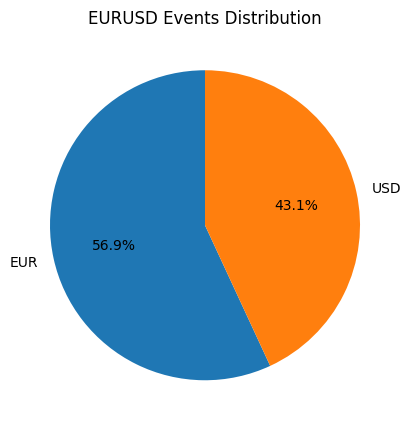

currency
EUR    15799
USD    11963
Name: count, dtype: int64

In [1027]:
currency_row_count = frame['currency'].value_counts()
fig,ax = plt.subplots(figsize=(5,8))
ax.pie(currency_row_count, autopct='%1.1f%%', startangle=90,labels=currency_row_count.index)
ax.set_title(DATA + ' Events Distribution')
plt.show()
currency_row_count


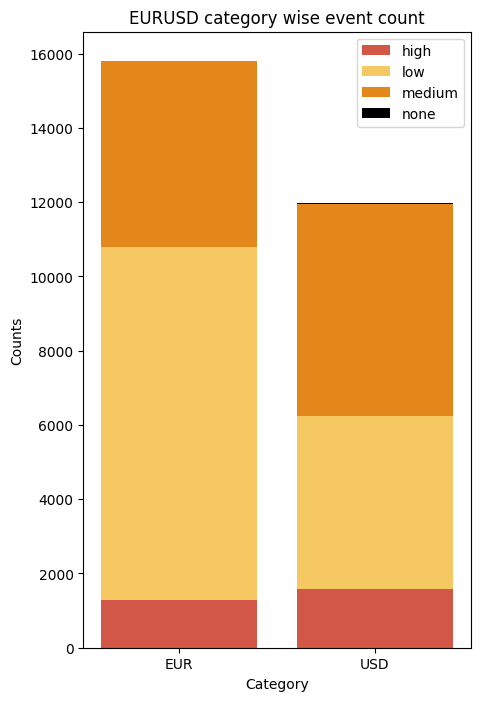

currency  impact
EUR       high      1295
          low       9492
          medium    5009
          none         3
USD       high      1581
          low       4647
          medium    5734
          none         1
Name: count, dtype: int64

In [1028]:
currency_impact = frame[['currency','impact']].value_counts().sort_index()
currency_impact_count = frame.groupby(['currency','impact']).size().unstack(fill_value=0)
fig,ax = plt.subplots(figsize=(5,8))
bottom = None
for impact in currency_impact_count.columns:
    if bottom is None:
        p = ax.bar(currency_impact_count.index, currency_impact_count[impact], label=impact,color=IMPACT_COLORS.get(impact))
        bottom = currency_impact_count[impact]
    else:
        p = ax.bar(currency_impact_count.index, currency_impact_count[impact], bottom=bottom, label=impact,color=IMPACT_COLORS.get(impact))
        bottom += currency_impact_count[impact]
ax.set_xlabel('Category')
ax.set_ylabel('Counts')
ax.legend()
ax.set_title( DATA + ' category wise event count')
plt.show()

# currency_impact_count
currency_impact

In [1029]:
frame[frame['impact']=='none'].tail()

,currency,description,impact,result,0h,1h,3h,5h,hour_of_day,month_of_year,day_of_week,price_change_1h,price_change_3h,price_change_5h
time,,,,,,,,,,,,,,
2015-05-21 12:30:00+00:00,USD,Continuing Jobless Claims(May 8),none,green,1.11366,1.11127,1.11189,1.11323,12,5,3,-0.00239,-0.00177,-0.00043
2015-07-27 08:00:00+00:00,EUR,IFO – Business Climate(Jul),none,green,1.10868,1.10777,1.10671,1.10702,8,7,0,-0.00091,-0.00197,-0.00166
2015-07-27 08:00:00+00:00,EUR,IFO – Current Assessment(Jul),none,green,1.10868,1.10777,1.10671,1.10702,8,7,0,-0.00091,-0.00197,-0.00166
2015-07-27 08:00:00+00:00,EUR,IFO – Expectations(Jul),none,green,1.10868,1.10777,1.10671,1.10702,8,7,0,-0.00091,-0.00197,-0.00166


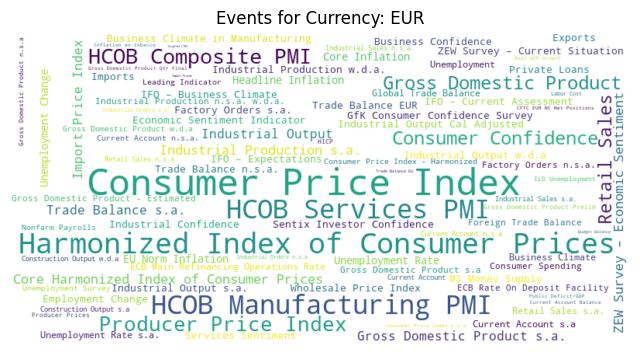

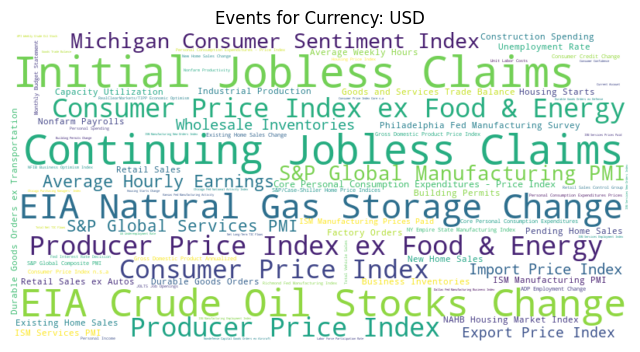

In [1030]:
def process_description(description):
    if '(' in description:
        return description[:description.index('(')].strip()
    else:
        return description.strip()
for currency in frame['currency'].unique():
    # Filter descriptions for the current currency
    descriptions = frame[frame['currency'] == currency]['description'].apply(process_description).value_counts()
    d = dict(zip(descriptions.index,descriptions.values))
    # # Generate word frequencies
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(d)
    # Plot the WordCloud
    plt.figure(figsize=(8, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Events for Currency: {currency}')
    plt.show()

In [1031]:
pd.concat([frame['currency'],frame['description'].apply(process_description)], axis=1)[['currency','description']].value_counts().sort_values(ascending=False)

currency  description                        
EUR       Consumer Price Index                   2077
          Harmonized Index of Consumer Prices    1302
          HCOB Services PMI                      1093
          HCOB Manufacturing PMI                 1087
          HCOB Composite PMI                      668
                                                 ... 
          Wholesale Prices n.s.a                    1
          9-Month Letras Auction                    1
USD       4-Week Bill Auction                       1
          Baker Hughes US Oil Rig Count             1
          20-Year Bond Auction                      1
Name: count, Length: 200, dtype: int64

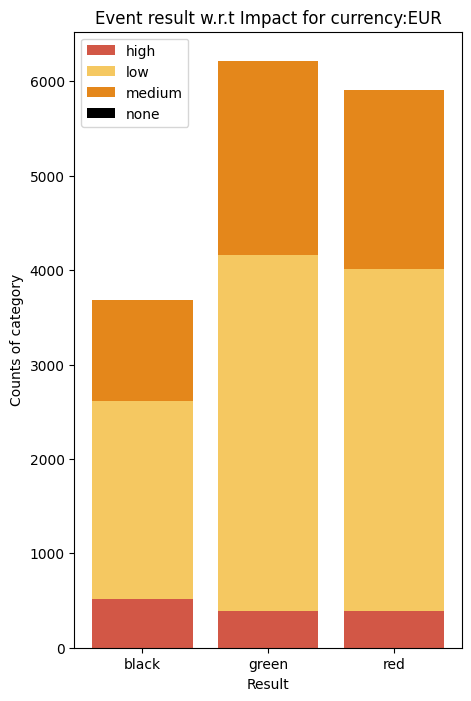

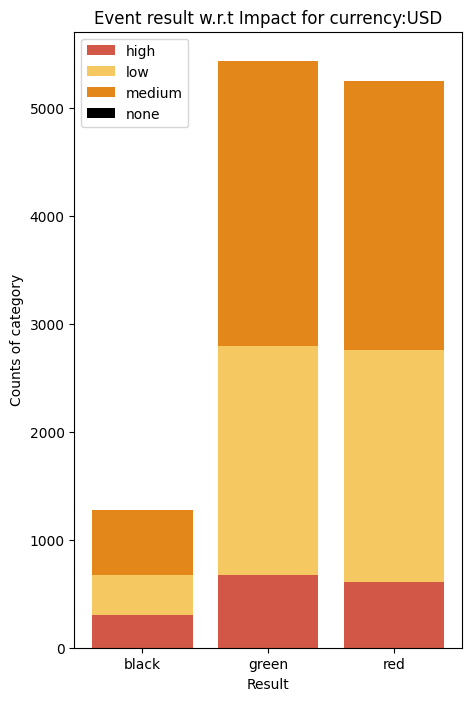

currency  impact  result
EUR       high    black      521
                  green      389
                  red        385
          low     black     2090
                  green     3775
                  red       3627
          medium  black     1068
                  green     2048
                  red       1893
          none    green        3
USD       high    black      301
                  green      672
                  red        608
          low     black      376
                  green     2121
                  red       2150
          medium  black      600
                  green     2640
                  red       2494
          none    green        1
Name: count, dtype: int64

In [1032]:
for currency in frame['currency'].unique():
    subframe = frame[frame['currency'] == currency]
    # currency_impact = subframe[['impact','result']].value_counts()
    currency_impact_count = subframe.groupby(['result','impact']).size().unstack(fill_value=0)
    fig,ax = plt.subplots(figsize=(5,8))
    bottom = None
    for impact in currency_impact_count.columns:
        if bottom is None:
            p = ax.bar(currency_impact_count.index, currency_impact_count[impact], label=impact,color=IMPACT_COLORS.get(impact))
            bottom = currency_impact_count[impact]
        else:
            p = ax.bar(currency_impact_count.index, currency_impact_count[impact], bottom=bottom, label=impact,color=IMPACT_COLORS.get(impact))
            bottom += currency_impact_count[impact]
    ax.set_xlabel('Result')
    ax.set_ylabel('Counts of category')
    ax.legend()
    ax.set_title('Event result w.r.t Impact for currency:' + currency)
    plt.show()

    currency_impact_count
    currency_impact
frame[['currency','impact','result']].value_counts().sort_index()

In [1033]:
frame.columns

Index(['currency', 'description', 'impact', 'result', '0h', '1h', '3h', '5h',
       'hour_of_day', 'month_of_year', 'day_of_week', 'price_change_1h',
       'price_change_3h', 'price_change_5h'],
      dtype='object')

In [1034]:
# for result in frame['result'].unique():
#     print(result)
#     fig,ax = plt.subplots(figure=(12,8))
#     ax.hist((frame[frame['result']==result]['1h']-frame[frame['result']==result]['0h']).std())
#     plt.show()


# frame['diff_1h_0h'] = frame['1h'] - frame['0h']

# # Group by 'result' and calculate the mean of the differences
# # result_diff_mean = frame.groupby('result')['diff_1h_0h']

# # Plotting
# fig, ax = plt.subplots(figsize=(12, 8))
# ax.bar(result_diff_mean.index, result_diff_mean.values)
# ax.set_xlabel('Result')
# ax.set_ylabel('Mean Difference (1h - 0h)')
# ax.set_title('Mean Difference between 1h and 0h by Result')
# plt.show()

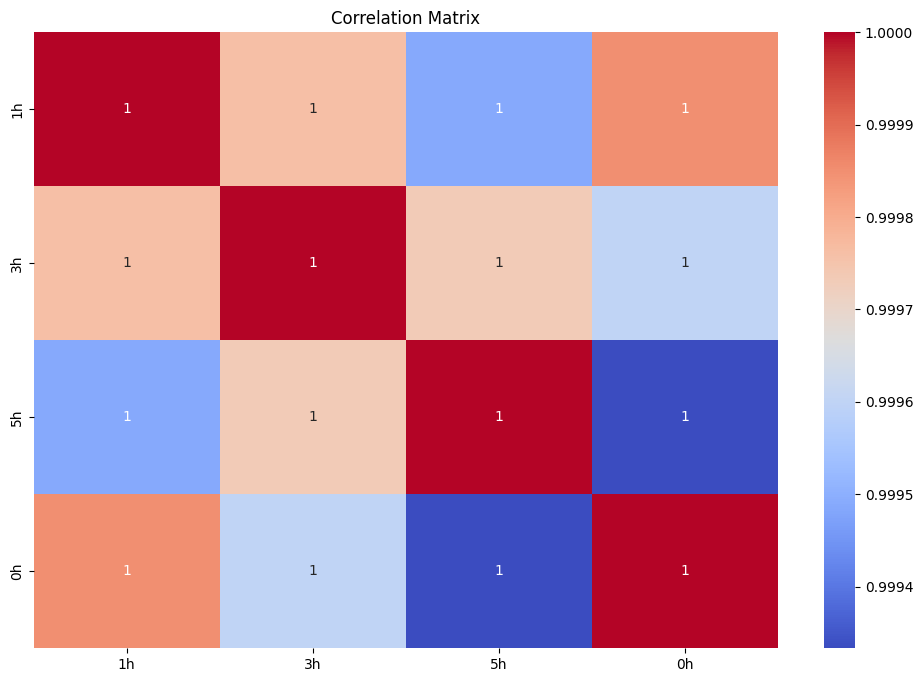

In [1035]:
#Visualize the correlation matrix
prices_columns = PREDICTED_FUTURE_PRICES.copy()
prices_columns.append('0h')
plt.figure(figsize=(12, 8))
correlation_matrix = frame[prices_columns].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()



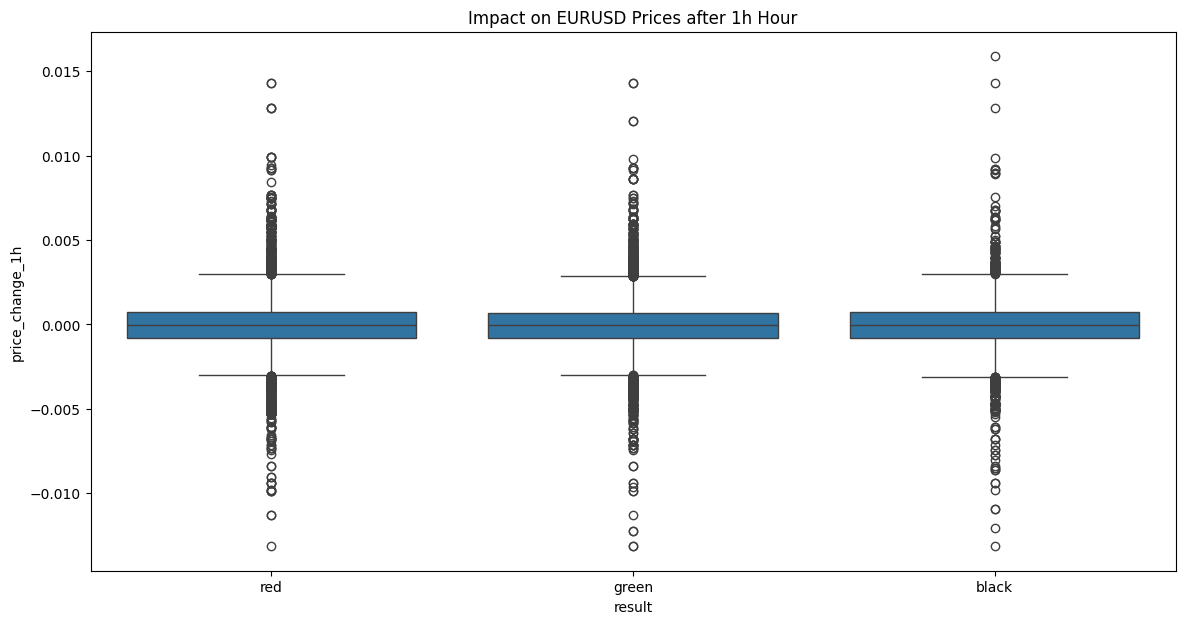

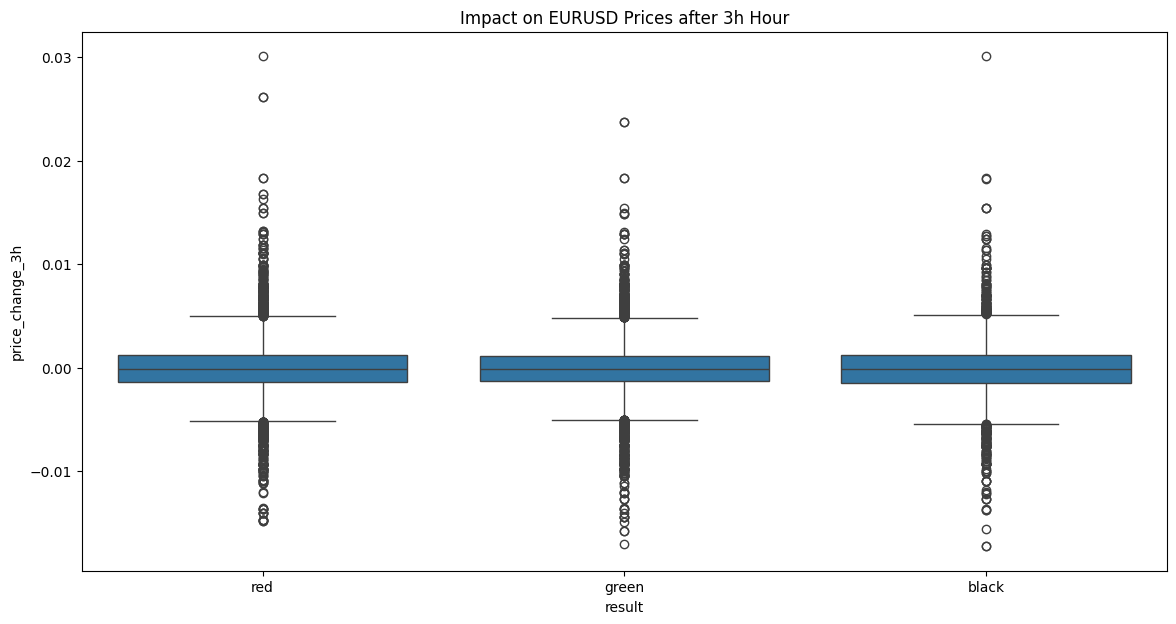

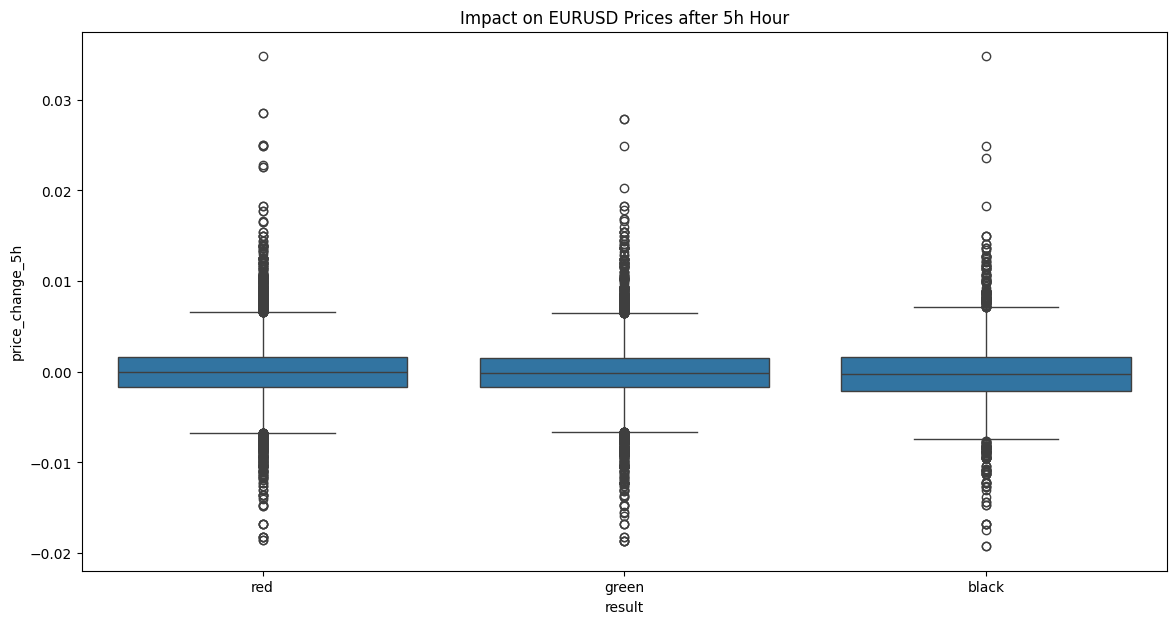

In [1036]:
# Visualize the impact of 'impact' on EURUSD prices
frame.columns
for price in PREDICTED_FUTURE_PRICES:
    plt.figure(figsize=(14, 7))
    sns.boxplot(x='result', y='price_change_'+ price , data=frame)
    plt.title('Impact on EURUSD Prices after '+ price +' Hour')
    plt.show()

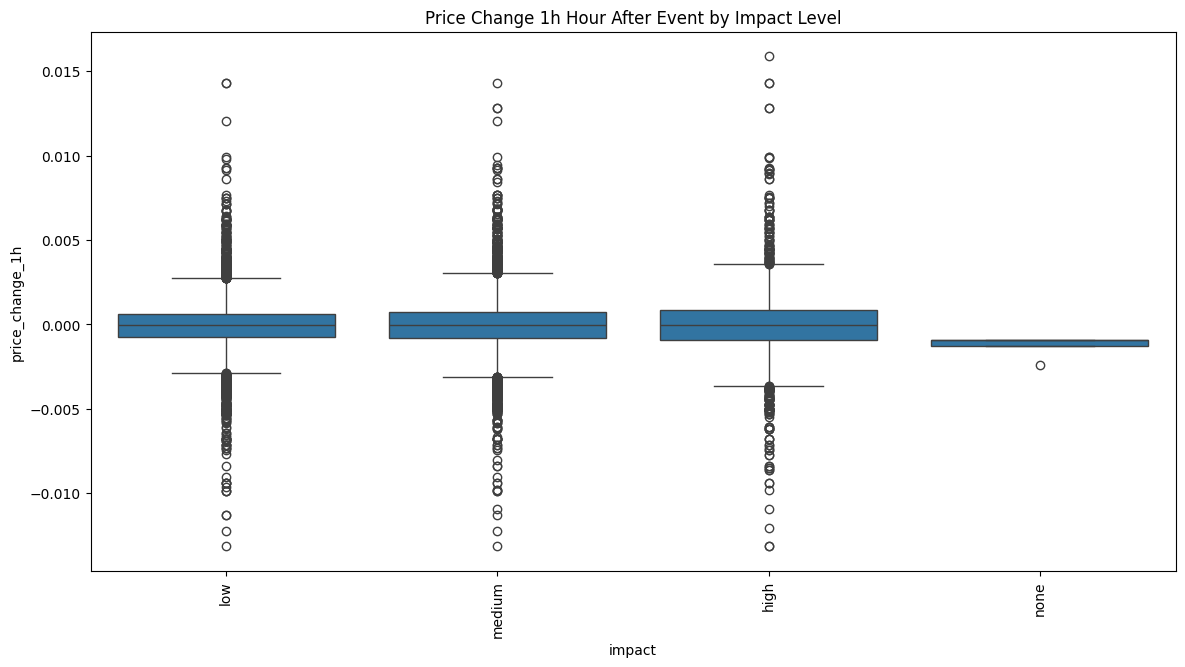

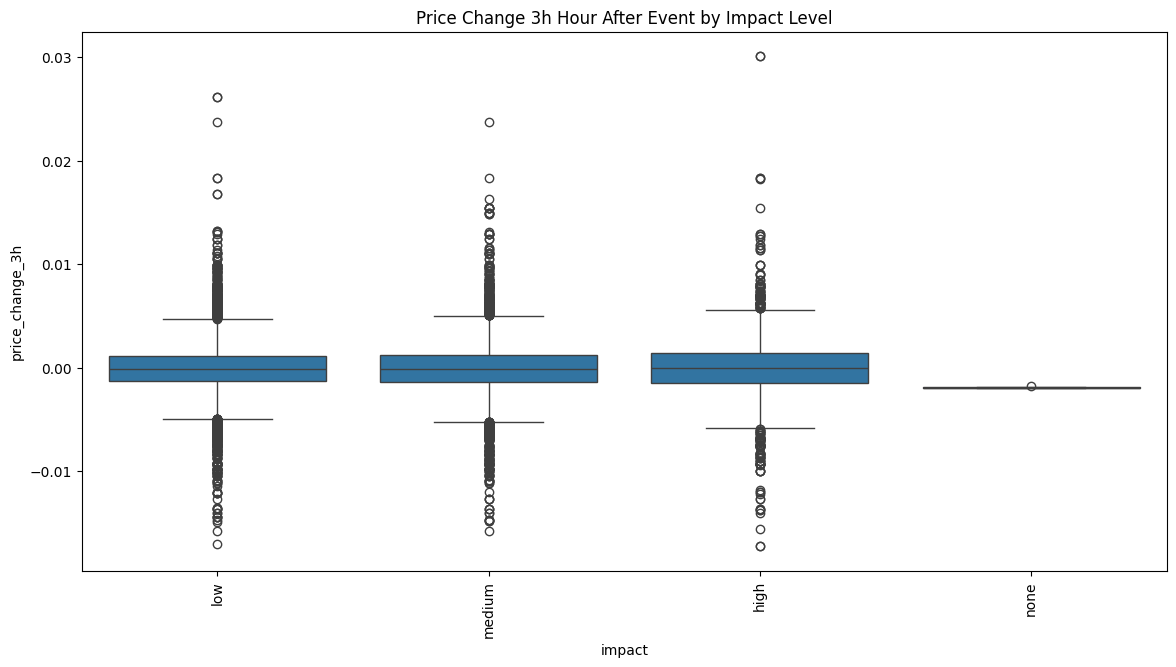

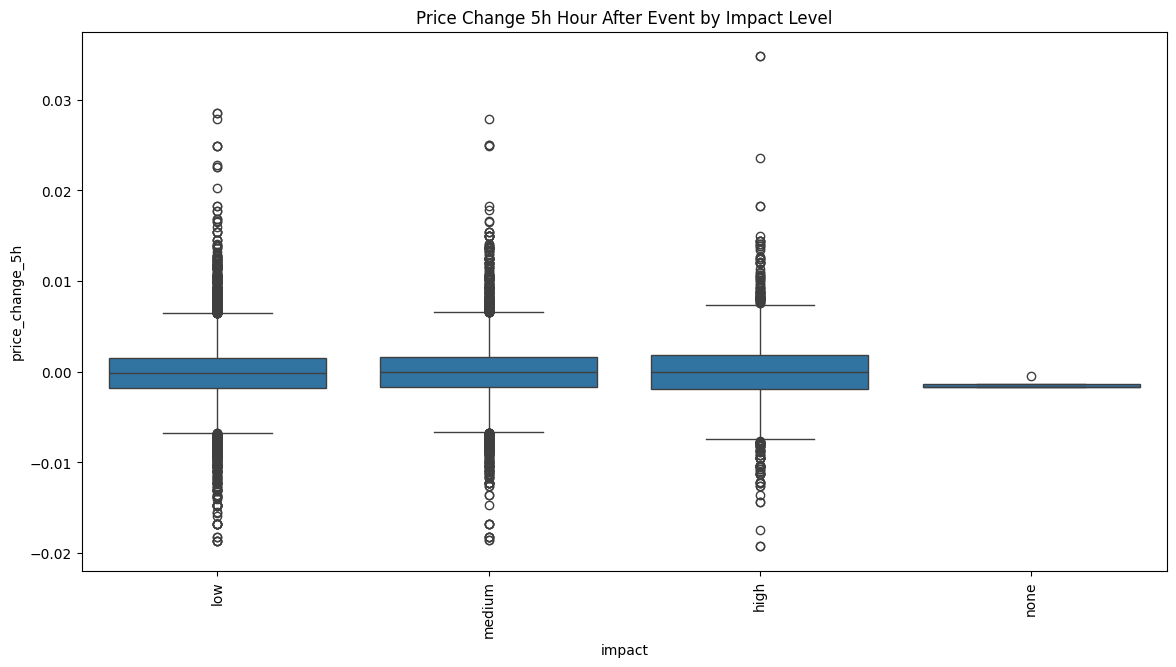

In [1037]:
# Impact of Events
for price in PREDICTED_FUTURE_PRICES:
    plt.figure(figsize=(14, 7))
    sns.boxplot(x='impact', y='price_change_'+price, data=frame)
    plt.title('Price Change ' + price + ' Hour After Event by Impact Level')
    plt.xticks(rotation=90)
    plt.show()

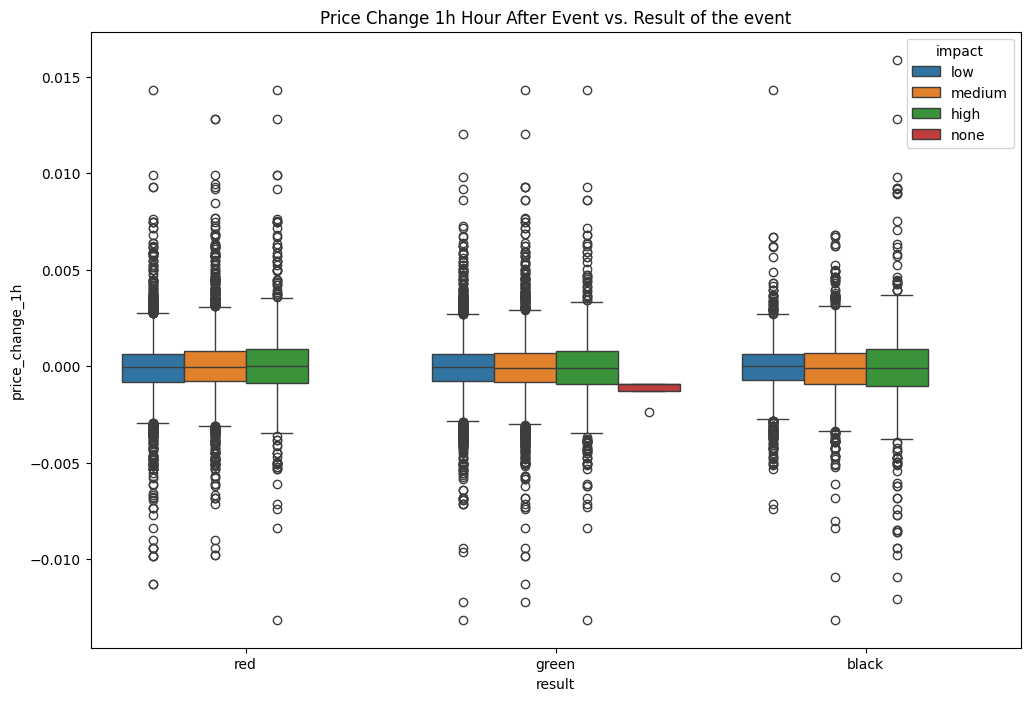

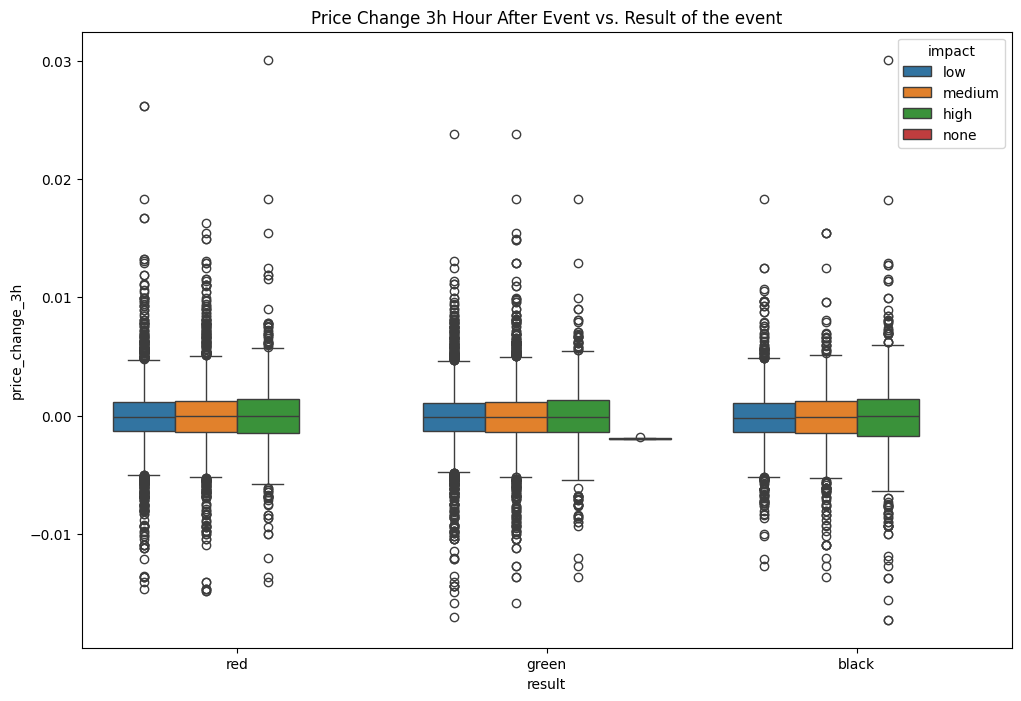

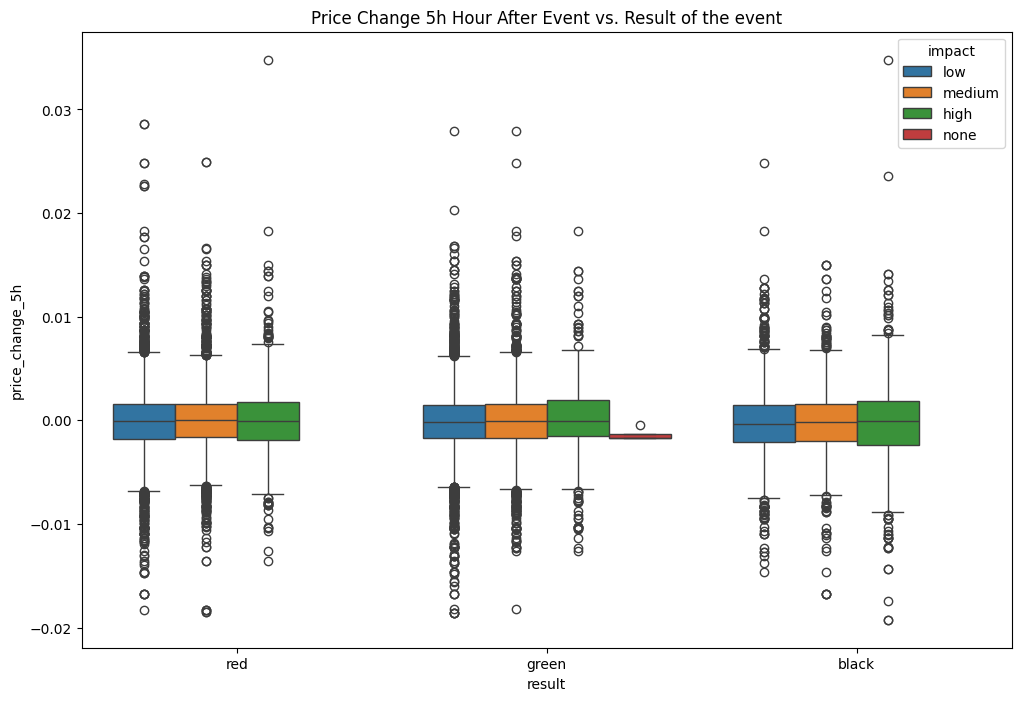

In [1038]:
for price in PREDICTED_FUTURE_PRICES:
    plt.figure(figsize=(12, 8))
    sns.boxplot(x='result', y='price_change_'+ price, hue='impact', data=frame)
    plt.title('Price Change '+ price +' Hour After Event vs. Result of the event')
    plt.show()

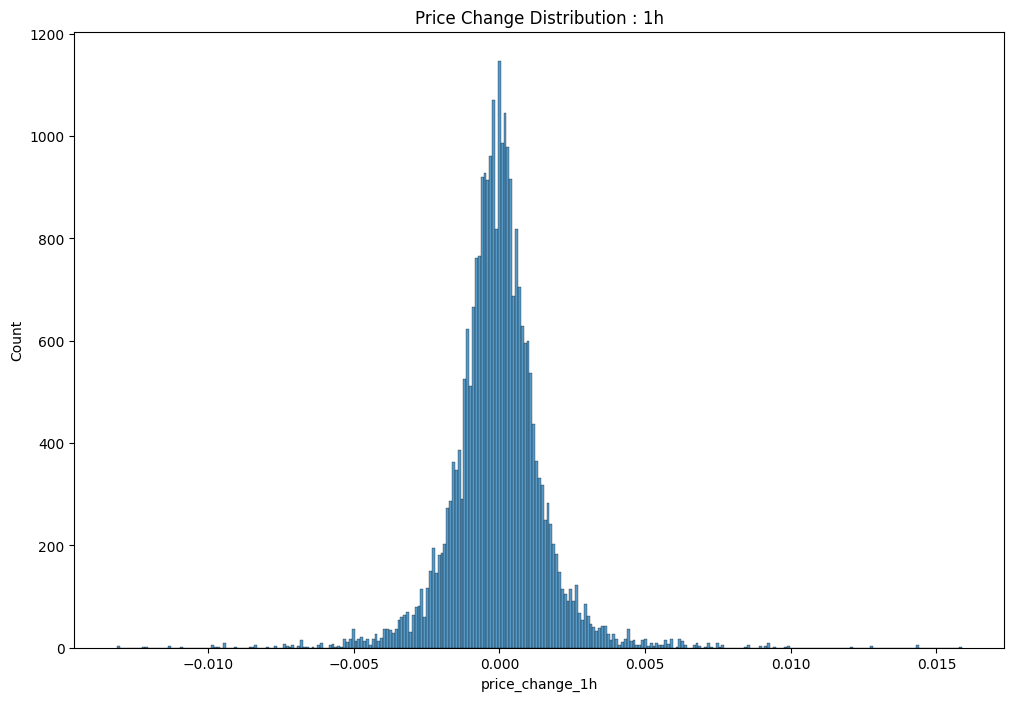

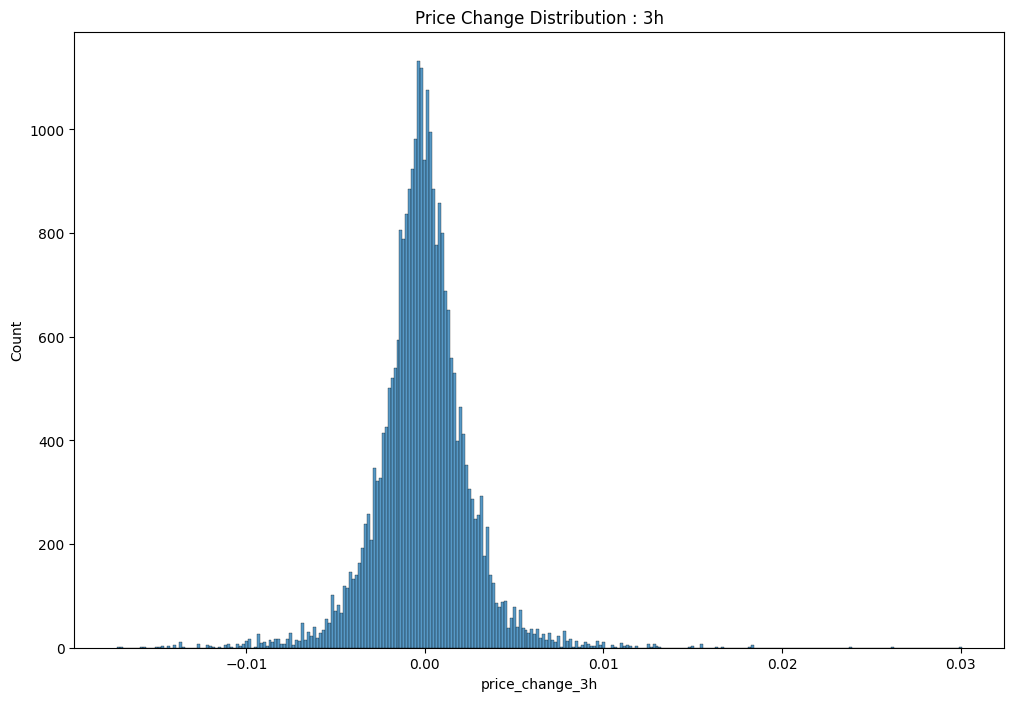

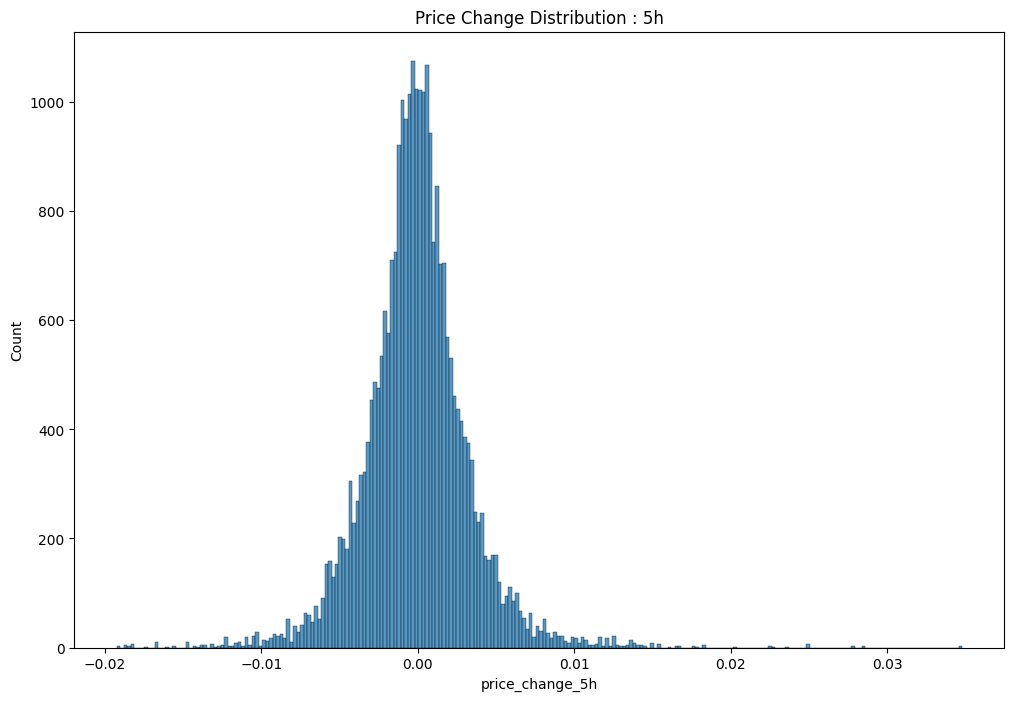

In [1039]:
for price in PREDICTED_FUTURE_PRICES:
    plt.figure(figsize=(12, 8))
    sns.histplot(x='price_change_'+ price, data=frame)
    plt.title('Price Change Distribution : ' + price)
    plt.show()
    # frame['price_change_'+ price].hist(figsize=(12,8))

In [1040]:
frame

,currency,description,impact,result,0h,1h,3h,5h,hour_of_day,month_of_year,day_of_week,price_change_1h,price_change_3h,price_change_5h
time,,,,,,,,,,,,,,
2013-01-02 09:13:00+00:00,EUR,HCOB Manufacturing PMI(Dec),low,red,1.32641,1.32448,1.32669,1.32535,9,1,2,-0.00193,0.00028,-0.00106
2013-01-02 09:43:00+00:00,EUR,HCOB Manufacturing PMI(Dec),low,green,1.32641,1.32448,1.32669,1.32535,9,1,2,-0.00193,0.00028,-0.00106
2013-01-02 09:48:00+00:00,EUR,HCOB Manufacturing PMI(Dec),low,black,1.32641,1.32448,1.32669,1.32535,9,1,2,-0.00193,0.00028,-0.00106
2013-01-02 09:53:00+00:00,EUR,HCOB Manufacturing PMI(Dec),medium,red,1.32641,1.32448,1.32669,1.32535,9,1,2,-0.00193,0.00028,-0.00106
2013-01-02 09:58:00+00:00,EUR,HCOB Manufacturing PMI(Dec),medium,red,1.32641,1.32448,1.32669,1.32535,9,1,2,-0.00193,0.00028,-0.00106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-14 08:00:00+00:00,EUR,Global Trade Balance(Apr),low,green,1.06868,1.06975,1.06888,1.06866,8,6,4,0.00107,0.00020,-0.00002
2024-06-14 09:00:00+00:00,EUR,Trade Balance n.s.a.(Apr),low,red,1.06975,1.06934,1.06688,1.06984,9,6,4,-0.00041,-0.00287,0.00009
2024-06-14 12:30:00+00:00,USD,Export Price Index (MoM)(May),low,red,1.06688,1.06866,1.07001,1.06989,12,6,4,0.00178,0.00313,0.00301


#### Encoder

In [1041]:


# # impact
# impact_mapping = {'none': 0,'low': 1, 'medium': 2, 'high': 3}
# frame['impact'] = frame['impact'].map(impact_mapping)

# # result
# result_mapping = {'black': 1, 'green': 2, 'red': 3}
# frame['result'] = frame['result'].map(result_mapping)


In [1042]:
# The description is having word like: event name (April) we are removing the april since we already have month column
# frame['description'] = frame['description'].apply(process_description)


In [1043]:
# frame.set_index([frame.index,'currency','description'],inplace=True)

In [1044]:
len(frame.description.unique())

3782

In [1045]:
labelencoder = LabelEncoder()
for i in ['currency','description','impact','result']:
    # print(frame.loc[:,i])
    frame[i] = labelencoder.fit_transform(frame[i])

In [1046]:
frame.description.max()

3781

In [1052]:
# frame.set_index([frame.index,'currency','description'],inplace=True)

In [1053]:
frame[frame.duplicated()].shape


(452, 14)

In [1054]:
frame.loc[frame.duplicated(), :].tail(30)

,currency,description,impact,result,0h,1h,3h,5h,hour_of_day,month_of_year,day_of_week,price_change_1h,price_change_3h,price_change_5h
time,,,,,,,,,,,,,,
2023-08-15 09:00:00+00:00,0,3771,2,1,1.09344,1.09288,1.09397,1.09265,9,8,1,-0.00056,0.00053,-0.00079
2023-09-01 07:45:00+00:00,0,2072,2,2,1.08482,1.08490,1.08328,1.08528,7,9,4,0.00008,-0.00154,0.00046
2023-09-05 07:45:00+00:00,0,2096,2,2,1.07479,1.07480,1.07322,1.07291,7,9,1,0.00001,-0.00157,-0.00188
2023-10-02 07:45:00+00:00,0,2092,2,1,1.05617,1.05387,1.05310,1.05155,7,10,0,-0.00230,-0.00307,-0.00462
2023-10-04 07:55:00+00:00,0,2116,2,1,1.04858,1.04981,1.04976,1.05069,7,10,2,0.00123,0.00118,0.00211
2023-10-17 09:00:00+00:00,0,3780,2,1,1.05528,1.05748,1.05487,1.05919,9,10,1,0.00220,-0.00041,0.00391
2023-11-02 09:45:00+00:00,0,2090,2,2,1.06234,1.06344,1.06639,1.06393,9,11,3,0.00110,0.00405,0.00159
2023-11-06 09:55:00+00:00,0,2114,2,1,1.07467,1.07481,1.07431,1.07385,9,11,0,0.00014,-0.00036,-0.00082
2023-12-01 09:55:00+00:00,0,2088,2,1,1.08975,1.08903,1.08763,1.08441,9,12,4,-0.00072,-0.00212,-0.00534


### Encoding the columns

In [1060]:
columns = frame.columns.values.tolist()
for item in PREDICTED_FUTURE_PRICES:
    columns.remove(item)
columns

['currency',
 'description',
 'impact',
 'result',
 '0h',
 'hour_of_day',
 'month_of_year',
 'day_of_week',
 'price_change_1h',
 'price_change_3h',
 'price_change_5h']

In [1063]:

features = frame[columns] # Add more features as needed
target_1h = frame['1h']
target_3h = frame['3h']
target_5h = frame['5h']

# Split data into training and testing sets
X_train, X_test, y_train_1h, y_test_1h = train_test_split(features, target_1h, test_size=0.2, random_state=42)
_, _, y_train_3h, y_test_3h = train_test_split(features, target_3h, test_size=0.2, random_state=42)
_, _, y_train_5h, y_test_5h = train_test_split(features, target_5h, test_size=0.2, random_state=42)

In [1064]:
from sklearn.linear_model import LinearRegression

# Train a Linear Regression model for each target
model_1h = LinearRegression()
model_3h = LinearRegression()
model_5h = LinearRegression()

model_1h.fit(X_train, y_train_1h)
model_3h.fit(X_train, y_train_3h)
model_5h.fit(X_train, y_train_5h)

# Predict and evaluate
y_pred_1h = model_1h.predict(X_test)
y_pred_3h = model_3h.predict(X_test)
y_pred_5h = model_5h.predict(X_test)

mse_1h = mean_squared_error(y_test_1h, y_pred_1h)
mse_3h = mean_squared_error(y_test_3h, y_pred_3h)
mse_5h = mean_squared_error(y_test_5h, y_pred_5h)

print(f'MSE for 1h prediction (Linear Regression): {mse_1h}')
print(f'MSE for 3h prediction (Linear Regression): {mse_3h}')
print(f'MSE for 5h prediction (Linear Regression): {mse_5h}')


MSE for 1h prediction (Linear Regression): 4.2352839968456e-31
MSE for 3h prediction (Linear Regression): 1.4955177237885396e-31
MSE for 5h prediction (Linear Regression): 5.17865324747288e-31


In [1065]:
from sklearn.tree import DecisionTreeRegressor

# Train a Decision Tree model for each target
model_1h = DecisionTreeRegressor(random_state=42)
model_3h = DecisionTreeRegressor(random_state=42)
model_5h = DecisionTreeRegressor(random_state=42)

model_1h.fit(X_train, y_train_1h)
model_3h.fit(X_train, y_train_3h)
model_5h.fit(X_train, y_train_5h)

# Predict and evaluate
y_pred_1h = model_1h.predict(X_test)
y_pred_3h = model_3h.predict(X_test)
y_pred_5h = model_5h.predict(X_test)

mse_1h = mean_squared_error(y_test_1h, y_pred_1h)
mse_3h = mean_squared_error(y_test_3h, y_pred_3h)
mse_5h = mean_squared_error(y_test_5h, y_pred_5h)

print(f'MSE for 1h prediction (Decision Tree): {mse_1h}')
print(f'MSE for 3h prediction (Decision Tree): {mse_3h}')
print(f'MSE for 5h prediction (Decision Tree): {mse_5h}')


MSE for 1h prediction (Decision Tree): 1.4695509634431546e-07
MSE for 3h prediction (Decision Tree): 2.592613622053893e-07
MSE for 5h prediction (Decision Tree): 4.2307820114069163e-07


In [1066]:
from sklearn.ensemble import RandomForestRegressor

# Train a Random Forest model for each target
model_1h = RandomForestRegressor(random_state=42)
model_3h = RandomForestRegressor(random_state=42)
model_5h = RandomForestRegressor(random_state=42)

model_1h.fit(X_train, y_train_1h)
model_3h.fit(X_train, y_train_3h)
model_5h.fit(X_train, y_train_5h)

# Predict and evaluate
y_pred_1h = model_1h.predict(X_test)
y_pred_3h = model_3h.predict(X_test)
y_pred_5h = model_5h.predict(X_test)

mse_1h = mean_squared_error(y_test_1h, y_pred_1h)
mse_3h = mean_squared_error(y_test_3h, y_pred_3h)
mse_5h = mean_squared_error(y_test_5h, y_pred_5h)

print(f'MSE for 1h prediction (Random Forest): {mse_1h}')
print(f'MSE for 3h prediction (Random Forest): {mse_3h}')
print(f'MSE for 5h prediction (Random Forest): {mse_5h}')


MSE for 1h prediction (Random Forest): 1.1293450558797094e-07
MSE for 3h prediction (Random Forest): 1.8457348818389714e-07
MSE for 5h prediction (Random Forest): 2.230732621019773e-07


In [1074]:
import xgboost as xgb

# Train an XGBoost model for each target
model_1h = xgb.XGBRegressor(random_state=42)
model_3h = xgb.XGBRegressor(random_state=42)
model_5h = xgb.XGBRegressor(random_state=42)

model_1h.fit(X_train, y_train_1h)
model_3h.fit(X_train, y_train_3h)
model_5h.fit(X_train, y_train_5h)

# Predict and evaluate
y_pred_1h = model_1h.predict(X_test)
y_pred_3h = model_3h.predict(X_test)
y_pred_5h = model_5h.predict(X_test)

mse_1h = mean_squared_error(y_test_1h, y_pred_1h)
mse_3h = mean_squared_error(y_test_3h, y_pred_3h)
mse_5h = mean_squared_error(y_test_5h, y_pred_5h)

print(f'MSE for 1h prediction (XGBoost): {mse_1h}')
print(f'MSE for 3h prediction (XGBoost): {mse_3h}')
print(f'MSE for 5h prediction (XGBoost): {mse_5h}')


MSE for 1h prediction (XGBoost): 5.117780203390906e-07
MSE for 3h prediction (XGBoost): 5.868172574807322e-07
MSE for 5h prediction (XGBoost): 6.300627987273129e-07


In [1073]:
from sklearn.svm import SVR

# Train an SVR model for each target
model_1h = SVR()
model_3h = SVR()
model_5h = SVR()

model_1h.fit(X_train, y_train_1h)
model_3h.fit(X_train, y_train_3h)
model_5h.fit(X_train, y_train_5h)

# Predict and evaluate
y_pred_1h = model_1h.predict(X_test)
y_pred_3h = model_3h.predict(X_test)
y_pred_5h = model_5h.predict(X_test)

mse_1h = mean_squared_error(y_test_1h, y_pred_1h)
mse_3h = mean_squared_error(y_test_3h, y_pred_3h)
mse_5h = mean_squared_error(y_test_5h, y_pred_5h)

print(f'MSE for 1h prediction (SVR): {mse_1h}')
print(f'MSE for 3h prediction (SVR): {mse_3h}')
print(f'MSE for 5h prediction (SVR): {mse_5h}')


MSE for 1h prediction (SVR): 0.008570860827053817
MSE for 3h prediction (SVR): 0.008572163079037517
MSE for 5h prediction (SVR): 0.008564145814683979


In [1070]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define a simple feedforward neural network
def create_model():
    model = Sequential()
    model.add(Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

# Train a neural network model for each target
model_1h = create_model()
model_3h = create_model()
model_5h = create_model()

model_1h.fit(X_train_scaled, y_train_1h, epochs=50, batch_size=32, verbose=0)
model_3h.fit(X_train_scaled, y_train_3h, epochs=50, batch_size=32, verbose=0)
model_5h.fit(X_train_scaled, y_train_5h, epochs=50, batch_size=32, verbose=0)

# Predict and evaluate
y_pred_1h = model_1h.predict(X_test_scaled)
y_pred_3h = model_3h.predict(X_test_scaled)
y_pred_5h = model_5h.predict(X_test_scaled)

mse_1h = mean_squared_error(y_test_1h, y_pred_1h)
mse_3h = mean_squared_error(y_test_3h, y_pred_3h)
mse_5h = mean_squared_error(y_test_5h, y_pred_5h)

print(f'MSE for 1h prediction (Neural Network): {mse_1h}')
print(f'MSE for 3h prediction (Neural Network): {mse_3h}')
print(f'MSE for 5h prediction (Neural Network): {mse_5h}')


174/174 [==============================] - 0s 938us/step
MSE for 1h prediction (Neural Network): 8.87972736926715e-07
MSE for 3h prediction (Neural Network): 1.0148137908741016e-06
MSE for 5h prediction (Neural Network): 4.943826633036681e-07
